<a href="https://colab.research.google.com/github/yhb1834/cv_prj2/blob/main/object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Detection을 위한 Tensorflow 모듈 설치
import tensorflow as tf
import tensorflow_hub as hub

# 이미지를 위한 모듈
import matplotlib.pyplot as plt #차트 그리기
import tempfile # 임시 파일/디렉터리 생성 
from six.moves.urllib.request import urlopen # url처리 (six: python2, 3 동시처리 가능한 모듈)
from six import BytesIO #데이터를 BytesIO로 읽은 뒤 이미지 Open

# For drawing onto the image. 배열
import numpy as np

# 파이썬 이미지 처리 pkg
from PIL import Image # 이미지 생성, 불러오기 등 제공
from PIL import ImageColor # color table 제공
from PIL import ImageDraw # 이미지에 텍스트 쓰기
from PIL import ImageFont # 이미지 내 폰트 설정
from PIL import ImageOps # 이미지 변형 

import time # 시간측정을 위한 함수

# Tensorflow 버전 출력 및 GPU 체크
print("Tensorflow version:", tf.__version__)
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

Tensorflow version: 2.8.2
The following GPU devices are available: 


In [2]:
# 이미지를 url로부터 다운 받은 후 resizing.
def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read() 
  image_data = BytesIO(image_data) # Bytes 파일에서 image 읽기
  pil_image = Image.open(image_data) # 이미지 오픈하여 pil_image에 저장 후
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS) # 이미지 조정
  pil_image_rgb = pil_image.convert("RGB") # RBG로 변환
  pil_image_rgb.save(filename, format="JPEG", quality=90) #JPEG로 저장
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename

### 이미지 내 bounding box 생성
def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color,font,thickness=4,display_str_list=()):

  # 이미지에 bounding box 좌표 설정 
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size # 이미지 원본 사이즈
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)
  
  # bounding box 테두리 그리기
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)],
            width=thickness, fill=color)   
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list] # box string 높이가 이미지 높이 초과 시, 하단에 폰트 삽입
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights) # 각 strings에 0.05 마진

 # 각 bounding box의 top 좌표가 전체 string height보다 크다면, 
# string을 bounding box위로 보내고, 아니면 bounding box 아래에 삽입
  if top > total_display_str_height: text_bottom = top
  else: text_bottom = top + total_display_str_height

  # list를 역방향으로 바꾸고, 아래에서 위로 출력 
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str, fill="black", font=font)
    text_bottom -= text_height - 2 * margin

### 박스 그리기. 박스의 좌표를 찾고, 그 좌표 위에서 선언된 함수를 이용
def draw_boxes(image, boxes, class_names, scores, max_boxes=50, min_score=0.1):
  # 색상 및 폰트 설정
  colors = list(ImageColor.colormap.values())
  font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",20)
  # 실제로 바운딩 박스 그리기 적용 
  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])  # 박스 좌표값
      display_str = "{}: {}%".format(class_names[i].decode("ascii"), int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(image_pil, ymin, xmin, ymax, xmax, color, font, display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

# 최종 이미지 출력
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

Image downloaded to /tmp/tmpz2xz7att.jpg.


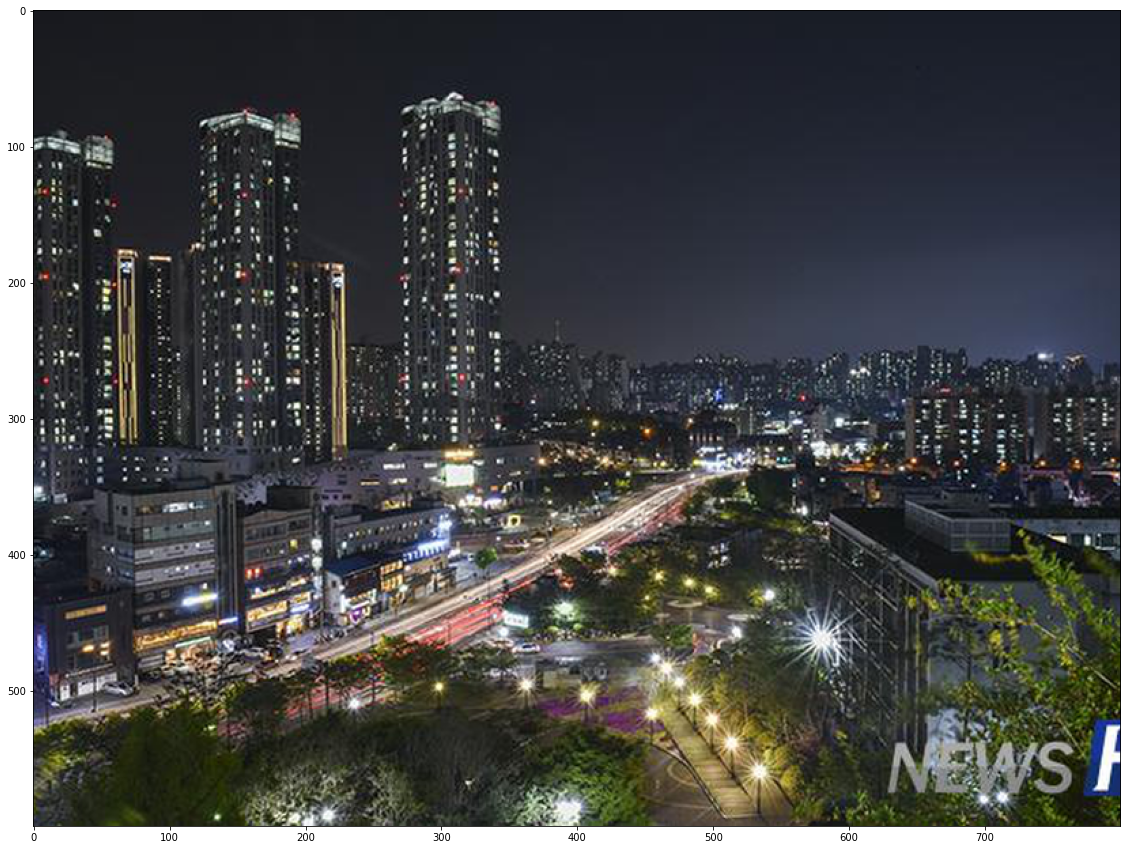

In [3]:
# 이미지예시로 들고와서 적용해보기
image_url = "https://www.hanyang.ac.kr/documents/20182/5404223/02153445495.jpg" 
downloaded_image_path = download_and_resize_image(image_url, 800, 600, True)

In [4]:
module_handle1 = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" # FasterRCNN+InceptionResNet V2: 정확도 높음 
module_handle2 = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"  # ssd+mobilenet v2: 빠르지만 정확도가 낮음

detector_faster_Rcnn = hub.load(module_handle1).signatures['default'] #detector에 사용할 모듈 저장
detector_ssd = hub.load(module_handle2).signatures['default'] #detector에 사용할 모듈 저장

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
